# Baseline model

## Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import rcParams
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import mean
from numpy.random import randn
from numpy.random import randint
from numpy.random import choice
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Concatenate
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import tensor_shape
from tensorflow.python.eager import def_function
from tensorflow.python.keras import initializers
from keras.initializers import RandomNormal
from tensorflow.python.keras import backend as K
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from numpy import asarray
import pickle


Using TensorFlow backend.


## Data preprocessing - first source 

### Loading and preparing the image data


In [2]:
#get the list of all files in the specified directory
path = 'CK PLUS/CK+48'
labels_list = os.listdir(path)
labels_list

['happy', 'contempt', 'fear', 'surprise', 'sadness', 'anger', 'disgust']

In [3]:
#creating the images list
images_data_list = []

for dataset in labels_list:
    imgs_per_label_list = os.listdir(path+'/'+ dataset)
    print ('Loaded the images of label '+'{}'.format(dataset) + ' ({})\n' .format(len(imgs_per_label_list)))
    for image in imgs_per_label_list:
        #load the image in grayscale mode
        input_image = cv2.imread(path + '/'+ dataset + '/'+ image,0)
        #change the width and height of the original image to 48*48
        image_resized = cv2.resize(input_image,(48,48))
        #append the resized image to the images_data_list
        images_data_list.append(image_resized)

#convert data to numpy array
images_data = np.array(images_data_list)
images_data.shape

Loaded the images of label happy (207)

Loaded the images of label contempt (54)

Loaded the images of label fear (75)

Loaded the images of label surprise (249)

Loaded the images of label sadness (84)

Loaded the images of label anger (135)

Loaded the images of label disgust (177)



(981, 48, 48)

### Preparing the labels 

In [4]:
number_of_classes = 7
number_of_samples = images_data.shape[0]

#create an 1D array of zeros with 981 elements.
labels = np.zeros(number_of_samples,dtype='int64')

labels[0:206]=0 #207
labels[207:260]=1 #54
labels[261:335]=2 #75
labels[336:584]=3 #249
labels[585:668]=4 #84
labels[669:803]=5 #135
labels[804:980]=6 #177

#labels array
y = np.array(labels)
X = images_data.reshape(images_data.shape[0],48,48,1) 

#Shuffle the dataset
X,y = shuffle(X,y, random_state=42)

### Data visualization

In [5]:
emotions_dict = {0:'happy',1:'contempt',2:'fear',3:'surprise',4:'sadness',5:'anger',6:'disgust'}

#get the dictionary keys and values 
print(emotions_dict.items())


def getdict_items(n):
    for a,b in emotions_dict.items() :
        if n==a :
            
            return b

dict_items([(0, 'happy'), (1, 'contempt'), (2, 'fear'), (3, 'surprise'), (4, 'sadness'), (5, 'anger'), (6, 'disgust')])


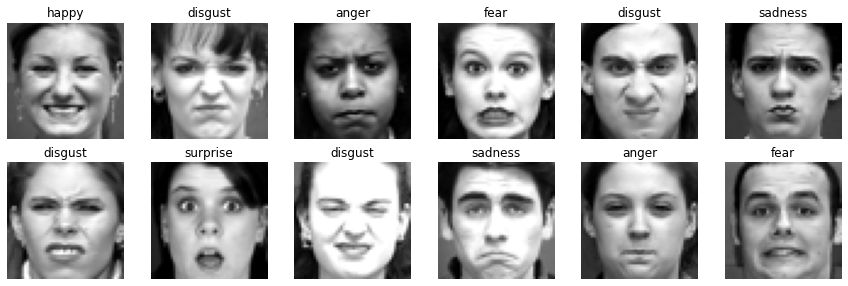

In [7]:
#Visualise the images and use getdict_items to obtain emotions as images titles
plt.rcParams["figure.figsize"] = (15,15)

for n,i in enumerate(list(randint(0,len(X),12))):
    plt.subplot(6,6,n+1)
    plt.imshow(X[i],cmap='gray') #only supports an image with RGB values (0-1 float or 0-255 int)
    plt.axis('off')
    plt.title(getdict_items(y[i]))

### Rescaling X (images) before training 

In [8]:
#Convert data into a float32 array 
X = X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5
#get data shape 
print(X.shape)
print(y.shape)

(981, 48, 48, 1)
(981,)


## Data preprocessing - second source 

In [9]:
df = pd.read_csv('icml_face_data.csv')
df.head()
print(df.shape)

(35887, 3)


In [10]:
df_split = np.array_split(df, 3)
df = df_split[0]
print(df.shape)

(11963, 3)


In [11]:
df['emotion'].value_counts()

3    2994
6    2085
4    2009
2    1720
0    1680
5    1285
1     190
Name: emotion, dtype: int64

### Match emotions to same label numbers of the previous data

In [12]:
df['emotion']=df['emotion'].replace({0:8,1:9,2:10,3:11,4:12,5:13,6:14}).replace({8:5,9:6,10:2,11:0,12:4,13:3,14:7})
df['emotion'].unique()

array([5, 2, 4, 7, 0, 3, 6])

### Prepare images and data labels

In [13]:
def preprocessing_data(df):  
    img_array = np.zeros(shape=(len(df), 48, 48))
    img_label = np.array(list(map(int, df['emotion']))) #map() function is used to iterate over an array
    
    for i, row in enumerate(df.index):
        img = np.fromstring(df.loc[row,' pixels'], dtype=int, sep=' ')
        img = np.reshape(img, (48, 48))
        img_array[i] = img
        
    return img_array, img_label

X_img, y_labels = preprocessing_data(df)

#Reshape images into (48,48,1) shape
X_img = X_img.reshape((X_img.shape[0], 48, 48, 1))
#Convert data into a float32 array 
X_img = X_img.astype('float32')

### Data visualization

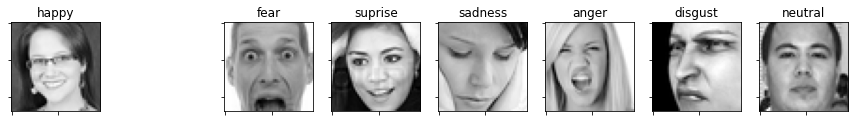

In [14]:
emotions = {0:'happy', 2: 'fear', 3: 'suprise', 4: 'sadness', 5: 'anger', 6: 'disgust', 7:'neutral'}

def plot_all_emotions():
    fig, axs = plt.subplots(1,8)
    fig.set_size_inches(15, 15)
    fig.delaxes(ax = axs[1])
    fig.subplots_adjust(hspace = 0.2, wspace=0.2)
    for i in emotions.keys():
        idx = df[df['emotion']==i].index[i]
        axs[i].imshow(X_img[idx], cmap='gray')
        axs[i].set_title(emotions[y_labels[idx]])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
plot_all_emotions()

### Rescaling X (images) before training 

In [15]:
# scale from [0,255] to [-1,1]
X_img = (X_img - 127.5) / 127.5
#get data shape 
print(X_img.shape)
print(y_labels.shape)

(11963, 48, 48, 1)
(11963,)


## Concatenate arrays from both sources

In [16]:
X = np.concatenate((X, X_img))
y = np.concatenate((y, y_labels))

#Shuffle the dataset
X,y = shuffle(X,y, random_state=42)

print(X.shape)
print(y.shape)

(12944, 48, 48, 1)
(12944,)


## Unconditional GAN -  BASELINE 

### Standalone discriminator model


In [17]:
def define_discriminator():
    model = Sequential()
    # downsample
    model.add(Conv2D(128, 3, input_shape=(48,48,1)))
    model.add(LeakyReLU(alpha=0.2)) #if the alpha is too close to zero it will result in gradients that may not be strong enough to "revive" a nearly dead unit.
    # downsample
    model.add(Conv2D(128,4,strides=2,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten()) #converting the data into a 1-dimensional array for inputting it to the next layer.
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8) #clipvalue (float) is set, the gradient of each weight is clipped to be no higher than this value.
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model 


In [18]:
# model summary
discriminator_baseline_model = define_discriminator()
discriminator_baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 128)       1280      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 46, 46, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 23, 23, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 67712)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 67712)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

2022-09-20 11:44:18.235801: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 11:44:18.236752: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


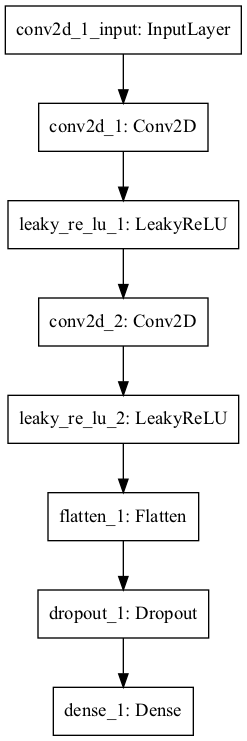

In [19]:
# model visualization
plot_model(discriminator_baseline_model, to_file='discriminator_baseline_model.png')

### Standalone generator model 

In [20]:
def define_generator():
    model = Sequential()
    # Transforming the input into a 24*24 128-channel feature map 
    model.add(Dense(128*24*24, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((24, 24, 128)))
    # upsample to 48x48
    model.add(Conv2DTranspose(576,4,strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Generator model, which maps the input of shape(latent_dim) into an image of shape (48,48,1)
    model.add(Conv2D(1, 7, activation='tanh', padding='same'))
    return model

In [21]:
# model summary
generator_baseline_model = define_generator()
generator_baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 73728)             7446528   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 73728)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 48, 48, 576)       1180224   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 48, 48, 576)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 1)         28225     
Total params: 8,654,977
Trainable params: 8,654,977
Non-trainable params: 0
____________________________________________

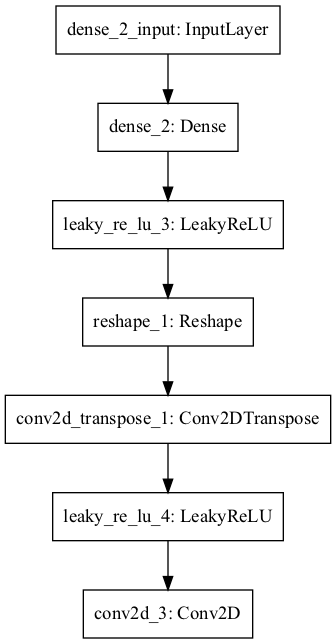

In [22]:
# model visualization
plot_model(generator_baseline_model, to_file='generator_baseline_model.png')

### Combined generator and discriminator model, for updating the generator

In [23]:
def define_gan(generator, discriminator):
    # Sets the discriminator weigths to non-trainable (this will only apply to the gan model)
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### Select real samples

Each time we update the GAN model, we will need a number of real images from dataset X. For this, we must choose a random selection of images from dataset X each time. The function below takes the dataset X as an argument and selects and returns a random sample of images with their associated class label for the discriminator, class = 1, designating that they are real images.

In [24]:
# select real samples
def real_samples(dataset,batch_size):
    # choose random images
    i = randint(0, dataset.shape[0],batch_size)
    # select images
    X = dataset[i]
    # generate class labels
    y = ones((batch_size, 1))
    return X, y

### Produce points in latent space to use as the generator's input

The generator model requires inputs that are random variables with a Gaussian distribution. We accomplished this by using the function below, which, given the size of the latent space and the required number of points as parameters, returns a batch of input samples.

In [25]:
def latent_points(dim_latent_space,num_points):
    # generate points in the latent space
    X_input = randn(dim_latent_space * num_points) #Return samples from the “standard normal” distribution
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(num_points, dim_latent_space)
    return X_input

### Create a number of fake examples with class labels using the generator

To create new images, we must feed the generator with points from the latent space. The function below generates points in the latent space and feeds them into the generator model after accepting the generator model and the size of the latent space as inputs. The function returns the created images along with the discriminator model class label for each one, class=0, designating  non-real images.

In [26]:
def fake_samples(generator, dim_latent_space, num_points):
    # generate points in latent space
    X_input = latent_points(dim_latent_space, num_points)
    # predict outputs
    X = generator.predict(X_input)
    # create class labels
    y = zeros((num_points, 1))
    return X, y

### Line plot for losses per epoch

In [27]:
# create a line plot of loss for the gan and save to file
def plot_history(loss1_disc,loss2_disc, g_loss_hist):
    # plot history
    plt.plot(loss1_disc, label='discriminator_real_loss')
    plt.plot(loss2_disc, label='discriminator_fake_loss')
    plt.plot(g_loss_hist, label='generator_loss')
    plt.legend()
    plt.close()

### Training the generator and discriminator

The GAN models can now be fitted. Nine training epochs are suitable for the model. By setting a batch size of 128 samples, each training epoch includes 101 batches of real and fake samples.  One batch of weight updates is created by first updating the discriminator model for a half batch of real samples, followed by a half batch of fake samples. The combined gan model is then used to update the generator. Important to mention that the fake samples have the class label set to 1. Consequently, this has the effect of upgrading the generator so that the subsequent batch of "real" 
samples are produced more successfully and much closer to the actual real ones.

In [ ]:
def train(generator_model, discriminator_model, gan_model, dataset, dim_latent_space, num_epochs=9, batch_size=128):
    batch_per_epoch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size / 2)
    # prepare lists for storing stats each iteration
    loss1_disc,loss2_disc, g_loss_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(num_epochs):
        loss1, loss2, g_loss = list(), list(),list()
        # enumerate batches over the training set
        for j in range(batch_per_epoch):
            # get randomly selected "real" samples
            X_real, y_real = real_samples(dataset, half_batch)
            # update discriminator model weights
            discriminator_loss1, _ = discriminator_model.train_on_batch(X_real, y_real) #train_on_batch allows you to expressly update weights based on a collection of samples you provide, without regard to any fixed batch size.
            loss1.append(discriminator_loss1)
            # generate "fake" samples
            X_fake, y_fake = fake_samples(generator_model, dim_latent_space, half_batch)
            # update discriminator model weights
            discriminator_loss2, _ = discriminator_model.train_on_batch(X_fake, y_fake)
            loss2.append(discriminator_loss2)
            # Produce points in latent space to use as the generator's input
            X_gan = latent_points(dim_latent_space,batch_size)
            # create inverted labels for the fake samples
            y_gan = ones((batch_size, 1))
            # update the generator via the discriminator's error
            generator_loss = gan_model.train_on_batch(X_gan, y_gan)
            g_loss.append(generator_loss)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
        # store losses per epoch 
        loss1_disc.append(mean(loss1))
        loss2_disc.append(mean(loss2))
        g_loss_hist.append(mean(g_loss))
    # save generator model to disk
    filename = 'generator_baseline.sav'
    pickle.dump(generator_model, open(filename, 'wb'))
    # line plots of loss
    plot_history(loss1_disc,loss2_disc, g_loss_hist)

# size of the latent space
dim_latent_space = 100
# create the discriminator
discriminator_model= define_discriminator()
# create the generator
generator_model = define_generator()
# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# load image data
dataset = X
# train model
train(generator_model,discriminator_model, gan_model, dataset, dim_latent_space)


### Loading the generator model and generating images

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def g_img_plot(samples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(samples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load the model from disk
model = pickle.load(open('generator_baseline.sav', 'rb'))
# generate images
latent_points = latent_points(100, 100)
# generate images
output = model.predict(latent_points)
# plot of 100 randomly generated items of clothing arranged into a 4×4 grid
g_img_plot(output, 4)